In [9]:
from scipy.stats import (shapiro, wilcoxon, fligner, levene, mood, ttest_ind)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

## The data 

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [4]:
# Set output preferences 
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

# Set data directory
data_directory = 'data'

# Read in .json files 
df_portfolio = pd.read_json(f'{data_directory}/portfolio.json', orient='records', lines=True)
df_profile = pd.read_json(f'{data_directory}/profile.json', orient='records', lines=True)
df_transcript = pd.read_json(f'{data_directory}/transcript.json', orient='records', lines=True)

# Verify 
assert df_portfolio.shape[0] > 0, "Portfolio data null"
assert df_profile.shape[0] > 0, "Profile data null"
assert df_transcript.shape[0] > 0, "Transcript data null"

## Exploratory Data Analysis 

Beside investigating missing values and the distribution of the data, we would like to investigate two key things: 

* `How strong is the relationship between the variables`. For example, does a customer creating an account on Sunday is more likely to use an offer? or third-age people are likely to go for high discounts?. 

* `Interaction Effects`. Questions like is income divided by gender more able to explain the result of the transaction?.

#### A. Missing Values

We don't expect to see missing values on `df_profile` dataset cause is a description provided by Starbucks. In the case of customer information, we see some missing values for gender and income 2175 rows of the 17000 total. 

![missing_values](figs/df_profile_missing_values.png)

First let's make some A/B testing of the characteristics of this group A with missing values and the group B with no missing values, we would like to investigate if their behavior is different or not. In case, these two group have the same behavior we will discard group A from the data. In statistical words, we have 

$$ H_{0} : = \text{Group A and Group B are different}, \\ H_{1} : = \text{Group A and Group B are equal}$$

and we would prove this by measuring across the variables the difference in **mean**, **median** and **standard deviation**. To achieve this, we will do some refactoring with the variable `became_member_on` because we only have one variable `age` to compare the difference across the two groups. For simplicity we will only take the year the user became a member (we could also consider how along ago does he became member, perhaps for the feature enginner step). 

In [15]:
# Retrieve year from became_member_on 
df_profile['became_member_year'] = df_profile.became_member_on.apply(lambda x: str(x)[:4]).astype(int)

In [25]:
cols_to_test = ['age', 'became_member_year']

# Divide data in group A and group B 
# Notice that we're sampling group B cause sample sizes most be equal 
group_A = df_profile[df_profile.gender.isnull()]
group_B = df_profile[~df_profile.gender.isnull()].sample(group_A.shape[0])

for col in cols_to_test: 
    
    # Test if data is normal 
    _, p_value = shapiro(group_A[col])
    normal_A = True if p_value > 0.05 else False
    print(f'The variable {col} for group A is Normal: {normal_A}')
    
    _, p_value = shapiro(group_B[col])
    normal_B = True if p_value > 0.05 else False
    print(f'The variable {col} for group B is Normal: {normal_B}')
    
    # If both variable follow a normal distribution apply parametric tests
    if (normal_A and normal_B): 
        # Parametric test for difference in variances (Levene's)
        _, p_value = levene(group_A[col],
                            group_B[col],
                            center='mean')
        result = True if p_value > 0.05 else False
        print(f'Variances are equal across {col}: {result}')
        
        # Parametric test for difference in means (t-test)
        _, p_value = ttest_ind(group_A[col],
                               group_B[col],
                               equal_var=result) # Are variances equal?
        result = True if p_value < 0.05 else False
        print(f'Mean is different across {col}: {result}')
     
    # Otherwise apply non-parametric tests
    else: 
        # Non parametric test for difference in variance (Fligner)
        _, p_value = fligner(group_A[col], 
                             group_B[col], 
                             center='median')
        result = True if p_value > 0.05 else False
        print(f'Variances are equal across {col}: {result}')

        # Non parametric test for difference in means (Wilcoxon)
        _, p_value = wilcoxon(group_A[col], 
                              group_B[col])
        difference = True if p_value < 0.05 else False
        print(f'Mean is different across {col}: {difference}')

    # Non parametric test for difference in medians
    _, p_value = mood(group_A[col], group_B[col])
    difference = True if p_value < 0.05 else False
    print(f'Median is different across {col}: {difference}')
    print('-----------------------------------------------', '\n')

The variable age for group A is Normal: True
The variable age for group B is Normal: False
Variances are equal across age: False
Mean is different across age: True
Median is different across age: True
----------------------------------------------- 

The variable became_member_year for group A is Normal: False
The variable became_member_year for group B is Normal: False
Variances are equal across became_member_year: False
Mean is different across became_member_year: True
Median is different across became_member_year: True
----------------------------------------------- 



> Notice that we're considering a sample from the Group B because we need equal samples size to perform the tests. 

We see that indeed there are statistical significant difference across `group_A` and `group_B` for the variables `age` and `became_member_year`. Thus we would assume that **Group A and Group B are different**, in other words, **we can't simply drop data of missing values**, and find way a way to impute that missing data.

#### B. Imputing Missing Values

Since Gender is not yet numeric, we need to find a way to consider `F, M` and `O` as numeric to impute it's values. For simplicity, we would assume `F==1`, `M==0` and `O==-1`. Notice that this does not invole any sort of bias or presumptions. 

In [31]:
# Set a mapping dictionary
gender_dict = {
    'F': 1,
    'M': 0,
    'O': -1
}

# Apply the mapping dict 
df_profile['gender'] = df_profile['gender'].map(gender_dict)

For imputing values, we could just take the easy way a perform, for example, a mean imputation. But, we would be using the MICE imputation algorithm cause it allow us to apply iteratively Linear Regression Models to learn the missing values.

In [89]:
# Initialize a Mice Imputer
mice_imp = IterativeImputer(sample_posterior=False, skip_complete=True, max_iter=50, random_state=0)
df_profile_imp = mice_imp.fit_transform(df_profile.drop(columns=['id', 'became_member_on']))

# Convert to pandas dataframe 
df_profile_imp = pd.DataFrame(df_profile_imp, columns=df_profile.drop(columns=['id', 'became_member_on']).columns)

# Round gender results 
df_profile_imp.gender = df_profile_imp.gender.apply(lambda x: np.round(x,0))

# Append became_member_on 
df_profile_imp = pd.concat([df_profile_imp, df_profile.became_member_on, df_profile.id], axis=1)

# Verify
assert df_profile_imp.shape[0] == df_profile.shape[0], "Rows are not the same as the original"

### C. Marginal distributions 

By exploring single variable behaivors we remark the following in each variable: 

* **Gender**. Men appear as frequently as Women. However, there's a representative proportion of other gender. 

* **Age**. Most of the clients are around 60 years. It is surprising to see that a high proportion of clients have more than 100 years becuase the general life expectancy is around 75 and 80 years.

* **Income**. Clients tend to come from a solid economic income.

* **Became Member Year**. Supposing we're on 2018, most of the clients come from the past year. By seeing this patterns, a good interesting question to follow up is if the purchase behavior of clients is the same across year, and what could be their churn rate.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


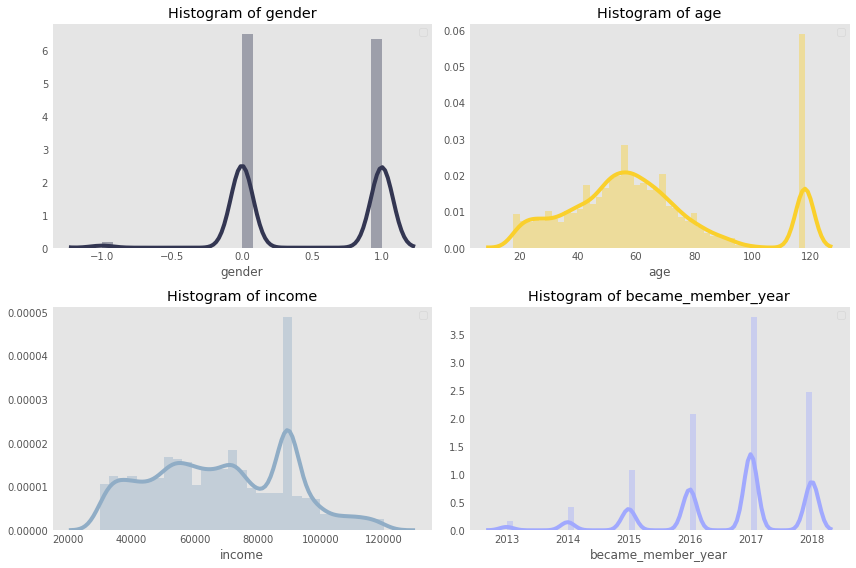

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_colors = ['#333652', '#FAD02C', '#90ADC6', '#A1A9FE']
plt.figure(figsize=(12,8))
plt.style.use('seaborn-bright')

for idx,col in enumerate(df_profile_imp.columns[:-1]):
    
    plt.subplot(2,2,idx+1)
    
    _ = sns.distplot(df_profile_imp[col],
                 color=plot_colors[idx])
    _ = plt.grid(False)
    _ = plt.legend(loc='upper right')
    _ = plt.title(f'Histogram of {col}')
     
_ = plt.tight_layout()   
_ = plt.show()

In [123]:
# Remove people with more than 100 years
df_profile_imp = df_profile_imp[df_profile_imp.age < 100]

## D. Purchase Behavior of clients across years

To investage the purchase behavior we first need to clean `df_transcript` and `df_portfolio`. Then, we could join the data to answer the question is the purchase behavior of clients different across years?.

In [118]:
# Retrieve value from dict 
df_transcript.value = df_transcript.value.apply(lambda x: tuple(dict(x).values())[0])

# Filter transaction events
df_transcript_transaction = df_transcript.query('event == "transaction"')

df_transcript_transaction.value = df_transcript_transaction.value.astype(float)

In [134]:
# Total purchases by user 
df_total_purchases = df_transcript_transaction.groupby('person').agg({'value':'sum'}).reset_index()

# Merge with user info 
df_user_purchase = df_profile_imp.merge(df_total_purchases,
                                        how='inner',
                                        left_on='id',
                                        right_on='person')

# Save memory
df_total_purchases = None

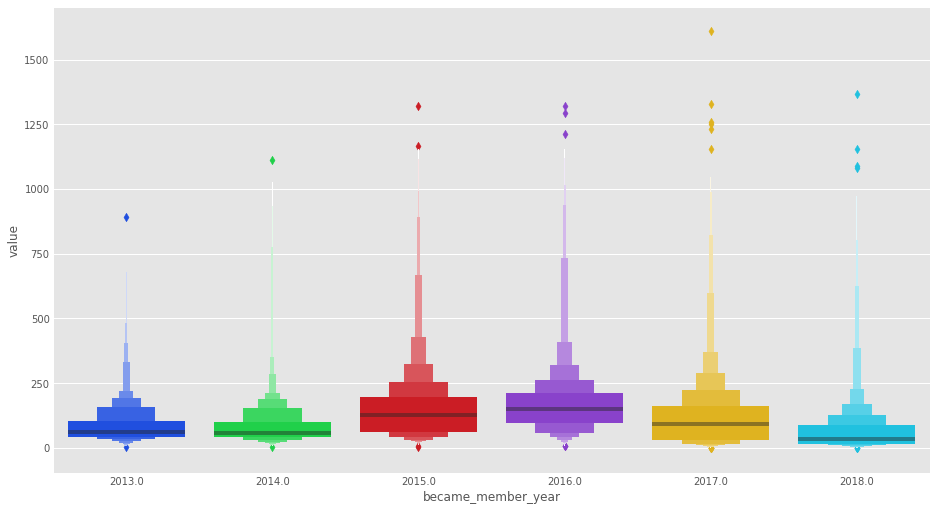

In [139]:
plt.figure(figsize=(14,8))

sns.boxenplot(x='became_member_year',
              y='value', 
              data=df_user_purchase,
              )

To further gain insight, we going to transform the variable income to explain these difference, that is, 

* Income < 60,000. Would be a Standard Income 

* Income < 100,000. Would be a High Income 

* Income > 100K. Would be a Top Income 

> **Note**. Notice that we're going to consider those users with a value less than 750 because those beyond it appear to be outlier. However this should be statistically tested.

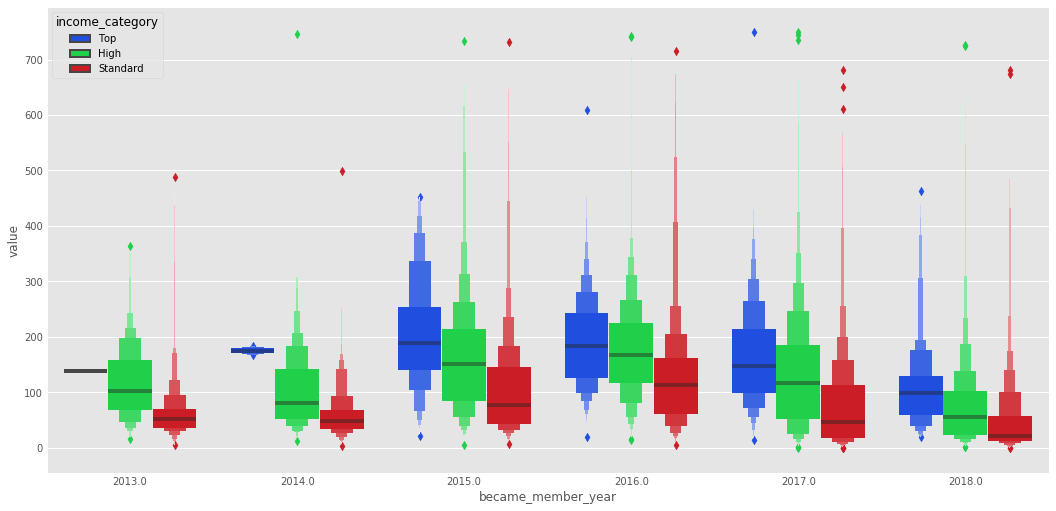

In [146]:
df_user_purchase['income_category'] = df_user_purchase.income.apply(lambda x: 'Standard' if x<60000 else ('High' if x<100000 else 'Top'))

plt.figure(figsize=(16,8))

sns.boxenplot(x='became_member_year',
              y='value', 
              hue='income_category',
              data=df_user_purchase.query('value < 750'),
              )

### Some Key Findings are: 
    
    * Customers since 2015 have a higher value purchase. 
    * The greater customer earns, the greater it will consume in a year. 

There's one more question I would like to answer, and that is the effect of promotions on these behavior, particularly for top consumers. 

## E. Does promotions affect purchase behavior? 

Now, we would be using `df_portfolio`. To first gain some understanding of the data we would count `offer received`, `offer viewed` and `offer completed` by each offer and see if there is some relationship with `difficulty` and `reward`. 

In [154]:
# Filter transactions 
df_transcript_offer = df_transcript.query('event != "transaction"')

# Calculate type of events by offer
offer_events = df_transcript_offer.groupby(['value', 'event']).agg({'person':'count'}).reset_index().rename(columns={'event':'event_type', 'person':'count'})

df_offer_events = df_portfolio.merge(offer_events, how='left', left_on='id', right_on='value')

# Save Memory 
offer_events = None

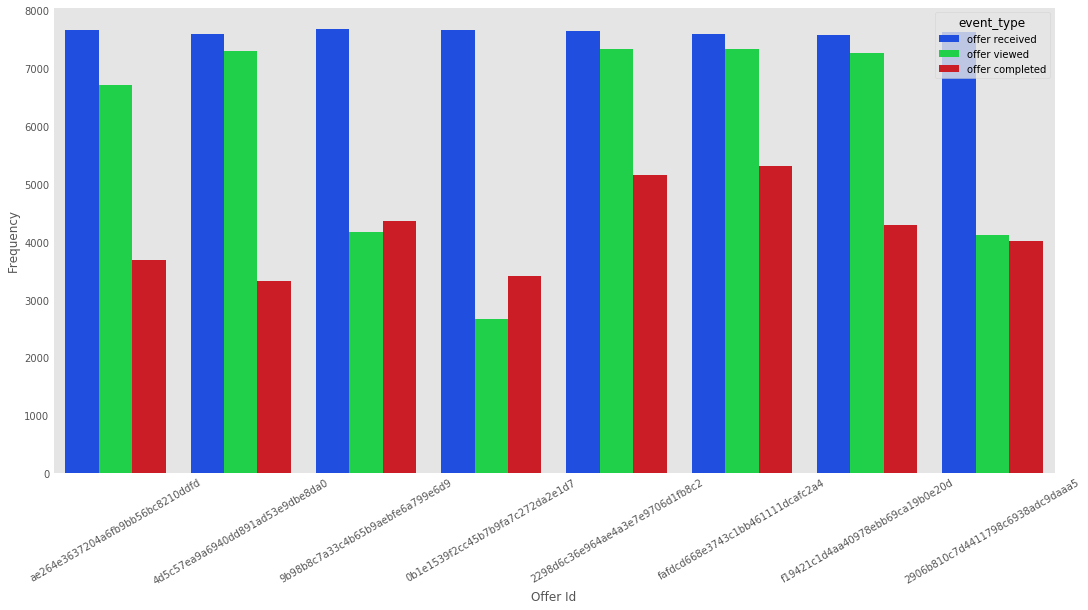

In [174]:
plt.figure(figsize=(16,8))

sns.barplot(x='id',
              y='count', 
              hue='event_type',
              hue_order=['offer received', 'offer viewed', 'offer completed'],
              data=df_offer_events.query('offer_type != "informational"'),
              )
plt.xticks(rotation=30)
plt.xlabel('Offer Id')
plt.ylabel('Frequency')
plt.grid(False)

In general, above 3000 clients seem to complete the offer, that is nearly a 40% effectiveness. However, there are two promotions that have a stronger effect that the other ones, let's keep it in the backlog to answer if this is could be explained by `reward` and `difficulty`. Now, let's these same difference by `offer_type`. 

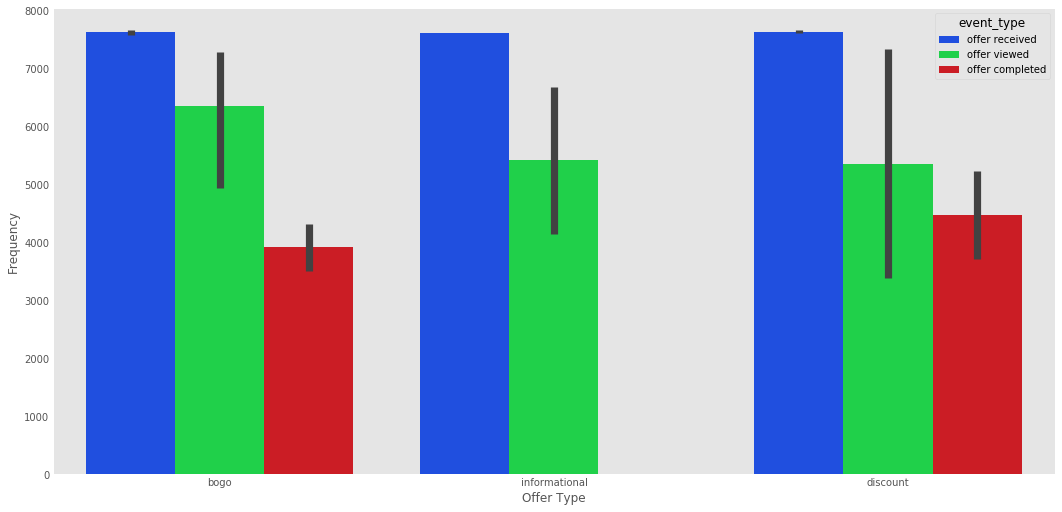

In [172]:
plt.figure(figsize=(16,8))

sns.barplot(x='offer_type',
            y='count', 
            hue='event_type',
            hue_order=['offer received', 'offer viewed', 'offer completed'],
            data=df_offer_events,
            )
plt.xlabel('Offer Type')
plt.ylabel('Frequency')
plt.grid(False)

We see that discounts offers are more effective than BOGO offers. As first assumption, we could say that BOGO offers are more difficult to complete cause they have a higher barrier entry completition. But let's find this out by the `difficulty` variable, we will neeed to calculate the completition rate as 

$$ CR = \dfrac{OC}{OR}, $$ 

where `OR` is offer received and `OC` is offer completed. Similarly we will calculate the attractiveness rate as 

$$ AR = \dfrac{OV}{OR}, $$

where `OV` is the offer viewed.

In [201]:
# Pivot data
df_offer_events_pivot = pd.pivot(df_offer_events, index='id', columns='event_type', values='count').reset_index()
df_offer_events_pivot.fillna(0, inplace=True)

# Calculate CR, AR
df_offer_events_pivot['CR'] = np.round(df_offer_events_pivot['offer completed'] / df_offer_events_pivot['offer received'],2)
df_offer_events_pivot['AR'] = np.round(df_offer_events_pivot['offer viewed'] / df_offer_events_pivot['offer received'], 2)

# Append type offer 
df_offer_events_pivot = df_offer_events_pivot.merge(df_offer_events[['id', 'offer_type', 'difficulty', 'duration']], on='id', how='left').drop_duplicates()

Text(0.5, 1, 'Attractivenes Rate explained by Difficulty')

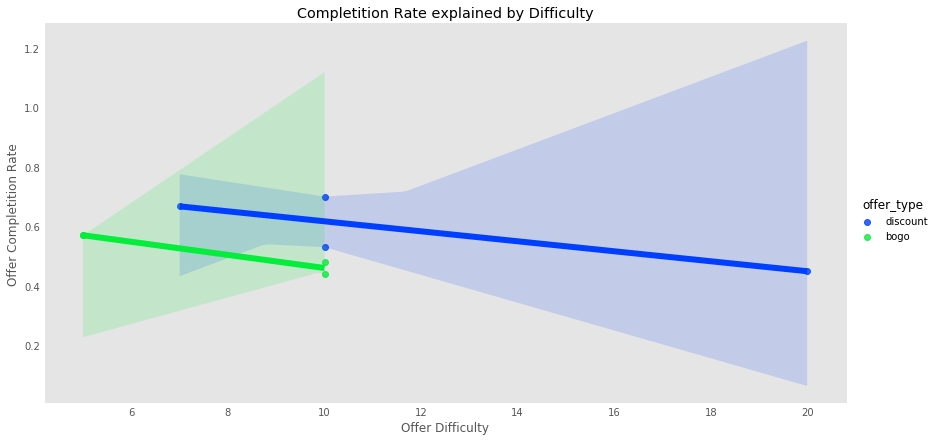

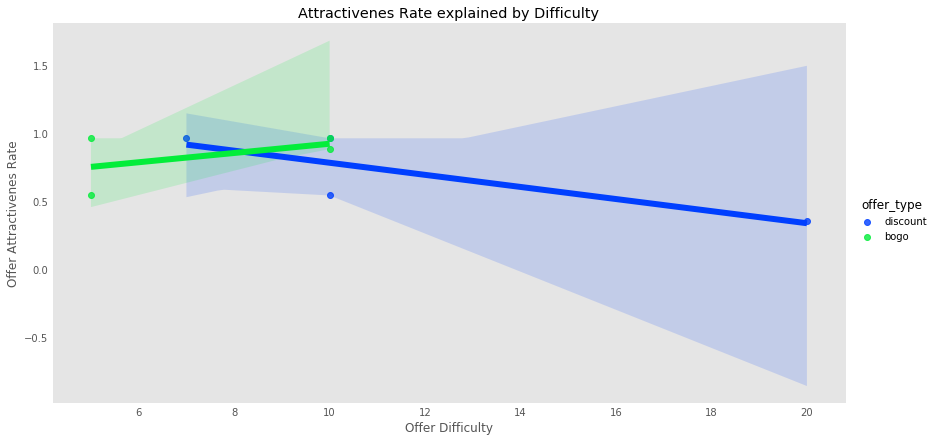

In [219]:
sns.lmplot(x='difficulty',
           y='CR', 
           hue='offer_type',
           data=df_offer_events_pivot.query('offer_type != "informational"'),
           height=6, 
           aspect=2, 
           )
plt.xlabel('Offer Difficulty')
plt.ylabel('Offer Completition Rate')
plt.grid(False)
plt.title('Completition Rate explained by Difficulty')

sns.lmplot(x='difficulty',
           y='AR', 
           hue='offer_type',
           data=df_offer_events_pivot.query('offer_type != "informational"'),
           height=6, 
           aspect=2, 
           )
plt.xlabel('Offer Difficulty')
plt.ylabel('Offer Attractivenes Rate')
plt.grid(False)
plt.title('Attractivenes Rate explained by Difficulty')

Text(0.5, 1, 'Attractivenes Rate explained by Duration')

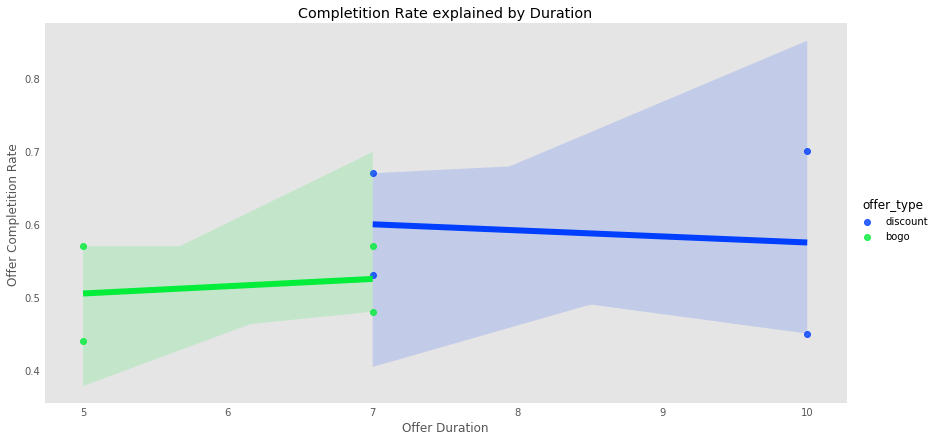

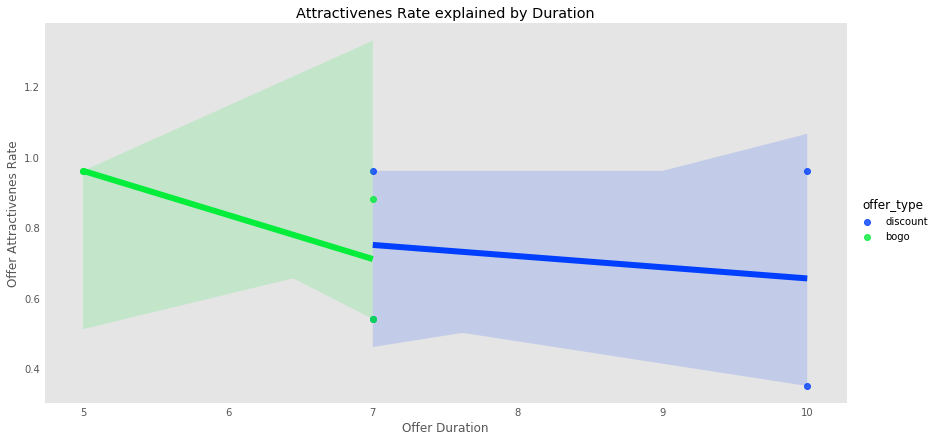

In [220]:
sns.lmplot(x='duration',
           y='CR', 
           hue='offer_type',
           data=df_offer_events_pivot.query('offer_type != "informational"'),
           height=6, 
           aspect=2, 
           )
plt.xlabel('Offer Duration')
plt.ylabel('Offer Completition Rate')
plt.grid(False)
plt.title('Completition Rate explained by Duration')

sns.lmplot(x='duration',
           y='AR', 
           hue='offer_type',
           data=df_offer_events_pivot.query('offer_type != "informational"'),
           height=6, 
           aspect=2, 
           )
plt.xlabel('Offer Duration')
plt.ylabel('Offer Attractivenes Rate')
plt.grid(False)
plt.title('Attractivenes Rate explained by Duration')

### Key Findings: 

* Discount offers effectiveness and completitions does not appear to be affected by the duration. That is, it appears to be the same letting two weeks an offer than a single week, however if letting the offer longer will generate longer revenue, it will be a good way to go. 

* It is natural to see that the more difficul the offer is, the lower it's completition and attractiveness rate. However, notice that this negative slope does not decline heavily, that is a good sign.

* Bogo offer have an interesting positive attractives behavior by difficulty. For example, if you get an offer of buy a coffe and baguette and get another free it is more likely to attract the consumer that a single item or less value offer. 

* Additionnally Bogo offers tend to take some time to complete, the higher the duration the higher the completition rate. Maybe they are high cost associated with bogo offers, therefore, they do not last longer. Finally, these positive effect is only slightly, therefore a further A/B testing would be necessary to proof or reject this hypothesis. 

## Save Data 

In [222]:
# Save profile and transcript processed
df_profile_imp.to_csv('data/profile_imputed.csv',index=False)
df_transcript.to_csv('data/transcript.csv', index=False)

# Some other data that could be further useful
df_offer_events_pivot.to_csv('data/offer_events_pivot.csv',index=False)
df_user_purchase.to_csv('data/user_purchase.csv', index=False)